In [1]:
from google.colab import drive                                     #mounting the drive to acces the data stored in google drive
drive.mount('/content/drive')


Mounted at /content/drive


In [22]:
!pip install emoji
import matplotlib.pyplot as plt  
import numpy as np               
import pandas as pd                                                #helps in data analysis and manipulation 
import pickle                                                   
import re                                                          # helps in the removal of unwanted characters from sentence eg:(@,#,&,*,...)
import emoji                                                       # a python library which tranfroms emoji's to meaningful words 
from nltk.stem import PorterStemmer as ps                          # reduces infected words to their word stem (eg:finally->final,historical->histori)
from tensorflow.keras.preprocessing.text import Tokenizer          # encodes the words to numbers which can be further used by the model to learn and understand them
from tensorflow.keras.preprocessing.sequence import pad_sequences  #helps in regularising the lengths of sequences 
from sklearn.model_selection import train_test_split               #splits the data into training and testing data 
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
import tensorflow as tf
import keras
from keras.metrics import Precision, Recall

In [3]:
csv_path = "/content/drive/MyDrive/ENTHIRE/airline_sentiment_analysis.csv"

class airline_data():
    def __init__(self,data_dir_path):
        self.df = pd.read_csv(data_dir_path)                                        #loading the csv file using pandas
        self.df = pd.concat([self.df["text"],self.df["airline_sentiment"]],axis=1) #concatenating the neccesary infromation from the data
    
    def process_text(self,text):
        new_text = text.lower()                                   #making all the characters lower case 
        new_text = re.sub(r'@\w+', '', new_text)                  # Remove @s
        new_text = re.sub(r'#', '', new_text)                     # Remove hashtags
        new_text = re.sub(r':', ' ', emoji.demojize(new_text))    # Turn emojis into words
        new_text = re.sub(r'http\S+', '',new_text)                # Remove URLs
        new_text = re.sub(r'\$\S+', 'dollar', new_text)           # Change dollar amounts to dollar
        new_text = re.sub(r'[^a-z0-9\s]', '', new_text)           # Remove punctuation
        new_text = re.sub(r'[0-9]+', 'number', new_text)          # Change number values to number
        new_text = new_text.split(" ")                            # splits the text into a list of strings after breaking the given text by the specified separator in our case it is " ".
        new_text = list(map(lambda x: ps().stem(x), new_text))    # Stemming the words
        new_text = list(map(lambda x: x.strip(), new_text))       # Stripping whitespace from the words
        if '' in new_text:
            new_text.remove('')
        return new_text                                           # returns sentence of words in the form of a list 

    def preprocess_data(self):
      self.Texts = self.df["text"].apply(self.process_text)                                                #cleans all the texts using the process text function
      sentiment_ordering = ['negative','positive']
      self.labels = self.df["airline_sentiment"].apply(lambda x:sentiment_ordering.index(x))               #converts the positive and negative labels to 1 and 0 respecctively
      

    def retrieve_vocab_info(self):
      self.preprocess_data()
      vocabulary = set()
      for text in self.Texts:                                                                               #goes through all the words in the data and adds the distinct words to the vocabulary
          for word in text:
                  vocabulary.add(word)

      self.vocab_length = len(vocabulary)   
      self.max_seq_length = 0
      for text in self.Texts:                                                                               #finds the length of sentence with maximum length out of all the sequences in the Texts.  
          if len(text) > self.max_seq_length:
              self.max_seq_length = len(text)
      return self.vocab_length,self.max_seq_length

    def tokenize_words(self):
      self.retrieve_vocab_info()                                                                             #retrieves information about the vocabulary length and maximum seqence length  
      self.training_sentences,self.testing_sentences,self.y_train,self.y_test = train_test_split(self.Texts,self.labels,train_size=0.7,random_state=10)  #splits the data into training and testing data
      tokenizer = Tokenizer(num_words=self.vocab_length,oov_token="<OOV>")  
      tokenizer.fit_on_texts(self.training_sentences)                                                        # maps all  distinct words in the training_sentences to numbers 
      word_index = tokenizer.word_index                                                                      # tokenizer.word_index is dictionary with words as keys and numbers as values formed by fitting the tokenizer on the training sentences
      self.training_sequences = tokenizer.texts_to_sequences(self.training_sentences)                        #creates sequences of tokens representing each sentence
      self.X_train = pad_sequences(self.training_sequences, maxlen=self.max_seq_length, padding='post')      #pads the sequence with zeros at the end to regularise the length of all the sequences to the maximum sequence length

      self.testing_sequences = tokenizer.texts_to_sequences(self.testing_sentences)
      self.X_test = pad_sequences(self.testing_sequences, maxlen=self.max_seq_length, padding='post')
      
      pickle.dump(tokenizer,open("/content/drive/MyDrive/ENTHIRE/GRU_Model/tokenizer_file3.pkl","wb"))       #saving the tokenizer using pickle so it can be used while deploying the model using fastAPI

      return self.X_train,self.X_test,self.y_train,self.y_test 

# DATA LOADING 
data = airline_data(csv_path)  
vocab_length,max_seq_length = data.retrieve_vocab_info()
X_train,X_test,y_train,y_test = data.tokenize_words() 

In [20]:
class LSTM_Model(keras.Model):
    def __init__(self):
        super(LSTM_Model,self).__init__()
        self.embed_layer = Embedding(vocab_length, output_dim = 32, input_length=max_seq_length)               # a word embedding where each word in the vocabulary is represented by a 32 dim vector
        self.conv1D     = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')                 # its basically like a 2D convolution operation which is restricted to only one direction the size of each filter here is (3*32) and the filter is convolved with the embedding of the 90 input words  from up to down
        self.max_pool1D = MaxPooling1D(pool_size=2)                                                            # MaxPooling1D takes the max over the vectors in the steps dimension(in our case 32)  but constrained to a pool_size for each stride. So a [10, 4, 10] tensor with pooling_size=2 and stride=2 is a [10, 2, 10] tensor after MaxPooling(pooling_size=2, stride=2)
        self.bi_LSTM = Bidirectional(LSTM(32))                                                                 # Biderectional-LSTMs train two LSTMs instead of one LSTMs on the input sequence. The first on the input sequence as-is and the other on a reversed copy of the input sequence
        self.dropout = Dropout(0.4)                                                                            # to reduce the model from overfitting At every training step, each neuron has a chance of being left out or dropped out of the collated contribution from connected neurons
        self.dense = Dense(1, activation='sigmoid')                                                            # the output is then  feeded into a dense neural network which gives as output a number between (0,1) note: since the sigmoid activation is used the outputs are between (0,1)
    
    def call(self, inputs, training=None):
        embed = self.embed_layer(inputs)
        conv_out = self.conv1D(embed)
        max_out = self.max_pool1D(conv_out)
        lstm_out = self.bi_LSTM(max_out)
        lstm_out_2 = self.dropout(lstm_out,training=training)
        dense_out = self.dense(lstm_out_2)
        return dense_out

model = LSTM_Model()

In [23]:
model.compile(optimizer="adam",loss="binary_crossentropy", metrics =['accuracy',Precision(), Recall()]) 
history = model.fit(X_train,y_train,validation_split=0.2,batch_size=32,epochs=100,
                              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1),tf.keras.callbacks.ReduceLROnPlateau()])#early stopping stops the training if there is no significant decrease in val_loss for atleast 3 epochs 
                                                                                                                                                                                     #reduceLROnPlateau its reduces the learning rate when is no significant improvement in val_loss

model.save("/content/drive/MyDrive/ENTHIRE/LSTM_Model/30_model/")

Epoch 1/100
202/202 [==============================] - 10s 21ms/step - loss: 0.4958 - accuracy: 0.7861 - precision: 0.4849 - recall: 0.1221 - val_loss: 0.2975 - val_accuracy: 0.8849 - val_precision: 0.9259 - val_recall: 0.5043
Epoch 2/100
202/202 [==============================] - 3s 14ms/step - loss: 0.1889 - accuracy: 0.9324 - precision: 0.8752 - recall: 0.7893 - val_loss: 0.2263 - val_accuracy: 0.9109 - val_precision: 0.8123 - val_recall: 0.7608
Epoch 3/100
202/202 [==============================] - 3s 14ms/step - loss: 0.0944 - accuracy: 0.9678 - precision: 0.9325 - recall: 0.9070 - val_loss: 0.2581 - val_accuracy: 0.9097 - val_precision: 0.8628 - val_recall: 0.6888
Epoch 4/100
202/202 [==============================] - 3s 14ms/step - loss: 0.0671 - accuracy: 0.9815 - precision: 0.9687 - recall: 0.9409 - val_loss: 0.2574 - val_accuracy: 0.9109 - val_precision: 0.8306 - val_recall: 0.7349
Epoch 5/100
202/202 [==============================] - 3s 14ms/step - loss: 0.0391 - accuracy: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ENTHIRE/LSTM_Model/30_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ENTHIRE/LSTM_Model/30_model/assets


In [25]:
import keras.backend as K
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9209
Precision : 0.8125
Recall    : 0.7867
F1 Score  : 0.7994


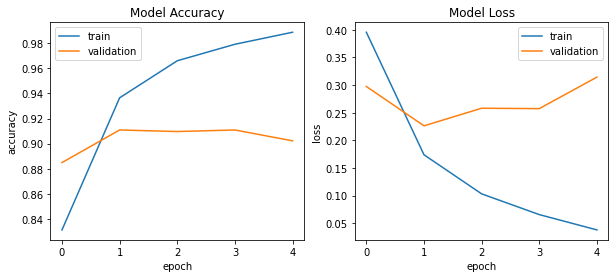

In [26]:
def plot_training_hist(history):
    # '''Function to plot history for accuracy and loss
        fig, ax = plt.subplots(1, 2, figsize=(10,4))
        # first plot
        #plots the training and validation accuracy over all the epochs
        ax[0].plot(history.history['accuracy'])
        ax[0].plot(history.history['val_accuracy'])
        ax[0].set_title('Model Accuracy')
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('accuracy')
        ax[0].legend(['train', 'validation'], loc='best')
        # second plot
        #plots the training and validation loss over all the epochs
        ax[1].plot(history.history['loss'])
        ax[1].plot(history.history['val_loss'])
        ax[1].set_title('Model Loss')
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('loss')
        ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)